# Notebook to process Rover CSV Files 

Plots a list of actions and telemetry

14/08/2019
Barry Whiteside - UCL

# To-Do:
- Set errors between 0 and 1 for a clear view
- Plot points rather than lines
- Scroll bar for viewing
- Save all plots
- Change labels from 0,1,2,3 to WACL, WACR etc.
- Create a calculation array that stores useful temps, voltages, HRC etc.
- Look at creating a nice interface for it all
- A general log processing output that has all the text statements I've created stored in a log file. 
- Break into powered chunks that can be easily navigated
- Also look for PanCam service errors such as 5,2

In [4]:
# Location of csv folder containing both the STDRAW and STDChrono files
top_dir = r'C:\WDir\PanCam EGSE\Logs\FS\20190821_104623_TB3_4_4_HRCDarkImages'
filt_dir = "\**\STDRawOcds*.csv"
directory = top_dir+filt_dir

# This finds all the HK files within the directories
import glob
TMfiles = glob.glob(directory,recursive=True)
print("TM CSV Files Found: " + str(len(TMfiles)))

filt_dir = "\**\STDChrono*.csv"
directory = top_dir+filt_dir
TCfiles = glob.glob(directory,recursive=True)
print("TC CSV Files Found: " + str(len(TCfiles)))

TM CSV Files Found: 0
TC CSV Files Found: 0


In [6]:
## TM File Parser

import pandas as pd
import numpy as np

#Define column names
df = pd.DataFrame()
dRV = pd.DataFrame()

col = [i for i in range (0,87+1)]

#Read CSV files
for file in TMfiles:
    dt = pd.read_csv(file, sep=';', header=0, dtype=object, index_col=False)
    dt.head()
    dl = dt[dt['NAME'].str.contains("AB.TM.TM_RMI00040")]
    if dl.empty == False:
        dg = dl.RAW_DATA.apply(lambda x: x[38:-4])
        dg = dg.apply(lambda x: bytearray.fromhex(x))
        dg = dg.apply(lambda x: pd.Series(list(x)))
        dg = dg.fillna('-1')
        dg = dg.astype(int)
        dg = dg.replace(-1, np.nan)
        dg['DT'] = pd.to_datetime(dl['GROUND_REFERENCE_TIME'], format='%d/%m/%Y %H:%M:%S.%f')
        df = df.append(dg, ignore_index=True)
    
    dP = dt[(dt.APID == '996') & ((dt.DISCRIMINATOR == '1') | (dt.DISCRIMINATOR == '2'))]
    if dP.empty == False:
        ByOffset = 85
        dS = dP.RAW_DATA.apply(lambda x: x[2+ByOffset*2+1:2+ByOffset*2+1+3])
        dH = dP.RAW_DATA.apply(lambda x: x[2+57*2+1: 2+57*2+1+3])
        dP['PanCam Current'] = dS.apply(lambda x: int(x,16)*1.1111/4095)
        dP['Heater Current'] = dH.apply(lambda x: int(x,16)*1.1111/4095)
        #dP['PanCam Current'] = dS
        dP['DT'] = pd.to_datetime(dP['GROUND_REFERENCE_TIME'], format='%d/%m/%Y %H:%M:%S.%f')
        dRV = dRV.append(dP, ignore_index=True)    
    
print("Number of PanCam TMs found: ", df.size)
df.head()

Number of PanCam TMs found:  41830


C:\Users\ucasbwh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ucasbwh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ucasbwh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,DT
0,21,7,0,0,3,250,123,144,0,0,...,32.0,62.0,68.0,97.0,168.0,97.0,168.0,62.0,68.0,2019-08-09 13:24:33.982
1,21,7,0,0,3,251,123,144,0,0,...,32.0,62.0,68.0,97.0,168.0,97.0,168.0,62.0,68.0,2019-08-09 13:24:34.981
2,21,7,0,0,3,252,123,144,0,0,...,32.0,62.0,68.0,97.0,168.0,97.0,168.0,62.0,68.0,2019-08-09 13:24:35.979
3,21,7,0,0,3,253,123,144,0,0,...,32.0,62.0,68.0,97.0,168.0,97.0,168.0,62.0,68.0,2019-08-09 13:24:36.977
4,21,7,0,0,3,254,123,144,0,0,...,32.0,62.0,68.0,97.0,168.0,97.0,168.0,62.0,68.0,2019-08-09 13:24:37.992


In [3]:
import matplotlib.pyplot as plt
 
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

ax1.plot(dRV['DT'], dRV['PanCam Current']);
ax1.plot(dRV['DT'], dRV['Heater Current'])

C:\Users\ucasbwh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [4]:

dP = dt[(dt.APID == '996') & (dt.DISCRIMINATOR == '1')]
ByOffset = 85
BiOffset = 4
Length = 3
Cur = 2+85*2+1
SF = 1.1111/4095
dS = dP.RAW_DATA.apply(lambda x: x[Cur:Cur+Length])
dS.apply(lambda x: int(x,16))
dP

,TEMPLATE,NAME,DESCRIPTION,ON_BOARD_TIME,GROUND_REFERENCE_TIME,RAW_ON_BOARD_TIME,APID,SERVICE,SUB_SERVICE,DISCRIMINATOR,SEVERITY,RAW_DATA,NB_VALUES
8,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 20:58:51.951,19/08/2019 20:58:53.755,NaN,996,3,25,1,NaN,OX0BE4EE9202C41003190124EDCA0BF39F012498025602...,0
14,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 20:58:52.951,19/08/2019 20:58:54.745,NaN,996,3,25,1,NaN,OX0BE4EE9402C41003190124EDCA0CF39F012485026D02...,0
22,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 20:58:53.951,19/08/2019 20:58:55.754,NaN,996,3,25,1,NaN,OX0BE4EE9602C41003190124EDCA0DF39F0124A7027302...,0
28,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 20:58:54.951,19/08/2019 20:58:56.757,NaN,996,3,25,1,NaN,OX0BE4EE9802C41003190124EDCA0EF3A0012466024602...,0
45,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 20:58:55.951,19/08/2019 20:58:57.745,NaN,996,3,25,1,NaN,OX0BE4EE9A02C41003190124EDCA0FF3A10124A1026002...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35109,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 21:56:45.951,19/08/2019 21:56:47.750,NaN,996,3,25,1,NaN,OX0BE4CB1102C41003190124EDD79DF39D0124A0026E02...,0
35117,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 21:56:46.951,19/08/2019 21:56:48.750,NaN,996,3,25,1,NaN,OX0BE4CB1302C41003190124EDD79EF39E012478025302...,0
35124,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 21:56:47.951,19/08/2019 21:56:49.751,NaN,996,3,25,1,NaN,OX0BE4CB1502C41003190124EDD79FF39E01248F025F02...,0
35129,RW,AB.TM.MRSP8001,Power HK LowSpeed,19/08/2019 21:56:48.951,19/08/2019 21:56:50.751,NaN,996,3,25,1,NaN,OX0BE4CB1802C41003190124EDD7A0F39E012498026302...,0


In [5]:
# TC and Action File Parser

dp = pd.DataFrame()

for file in TCfiles:
    dt = pd.read_csv(file, sep=';', header=0, dtype=object, index_col=False)
    dp = dt[dt['DESCRIPTION'].str.contains("Pan Cam", na=False) & dt['NAME'].str.contains("CRM", na=False)]
    dm = dp['VARIABLE_PART'].str.split(',', -1, expand=True)
    #dm = dp[['NAME','DESCRIPTION','GROUND_REFERENCE_TIME']] dm
    TC = pd.concat([dp[['NAME','DESCRIPTION','GROUND_REFERENCE_TIME']],dm.loc[:,9:]],axis=1)
    TC['DT'] = pd.to_datetime(TC['GROUND_REFERENCE_TIME'], format='%d/%m/%Y %H:%M:%S.%f')
TC['ACTION'] = TC['DESCRIPTION'].map(lambda x: x.lstrip('Pan Cam'))
TC['LEVEL'] = 1;
TC.head()

,NAME,DESCRIPTION,GROUND_REFERENCE_TIME,9,10,11,12,13,14,15,...,29,30,31,32,33,34,35,DT,ACTION,LEVEL
616,AB.TC.CRMI0316,Pan Cam Load TM File,19/08/2019 15:22:48.708,SID=0x1,FI1_=0x177C,PRMI1990_=2097152,PRMI1991_=2097152,PRMI1992_=2097152,None,None,...,None,None,None,None,None,None,None,2019-08-19 15:22:48.708,Load TM File,1
619,AB.TC.CRMI0172,Pan Cam Load Switch On,19/08/2019 15:22:52.247,SID=0x1,FI1_=0x1778,PRMI1955_=100,PRMI1956_=-100,None,None,None,...,None,None,None,None,None,None,None,2019-08-19 15:22:52.247,Load Switch On,1
622,AB.TC.CRMI0173,Pan Cam Report Switch On,19/08/2019 15:22:58.623,SID=0x1,FI1_=0x1778,None,None,None,None,None,...,None,None,None,None,None,None,None,2019-08-19 15:22:58.623,Report Switch On,1
641,AB.TC.CRMI0156,Pan Cam Initialise,19/08/2019 15:23:45.271,SID=0x1,FI1_=0x68,FI2_=0x1,FI3_=0x0,PRMI1912_=16,FI4_=0x0,PRMI1913_=16,...,None,None,None,None,None,None,None,2019-08-19 15:23:45.271,Initialise,1
682,AB.TC.CRMI0158,Pan Cam Init Cam,19/08/2019 15:25:33.252,SID=0x1,FI1_=0x68,FI2_=0x3,PRMI1916_=HRC,None,None,None,...,None,None,None,None,None,None,None,2019-08-19 15:25:33.252,Init Cam,1


# Importing LabView EGSE Files

In [14]:
# First paste location of files to plot here
top_dir = r'C:\WDir\PanCam EGSE\Logs\FS Calibration\20191016_115233_7mBar_Geom'

TC_filt_dir = "\**\RMAP_CMD*.txt"
TC_directory = top_dir+TC_filt_dir
TM_filt_dir = "\**\*HK*.txt"
TM_directory = top_dir+TM_filt_dir

# This finds all the HK files within the directories
import glob
import pandas as pd
import numpy as np

TC_files = glob.glob(TC_directory,recursive=True)
print("RMAP CMD Files Found: " + str(len(TC_files)))
HKs = glob.glob(TM_directory,recursive=True)
print("RMAP HK Files Found:  " + str(len(HKs)))

#Define column names
TC_hdr_strings = ['Date','Time', 'Description']
TC_hdr_CMD = [i for i in range(0,11)]
TC_hdr = TC_hdr_strings + TC_hdr_CMD
TC_col = TC_hdr_CMD
TC = pd.DataFrame()

hdr_strings = ['Date','Time']
hdr_HKE = [i for i in range(0,71+1)]
hdr_HKNE = [i for i in range (72,87+1)]
hdr = hdr_strings + hdr_HKE + hdr_HKNE
TM_col = hdr_HKE
df = pd.DataFrame()

#Read CSV files
for file in TC_files:
    dt = pd.read_csv(file, sep='\t',names=TC_hdr, dtype=object)

    if dt['Description'].iloc[-1] == '  ' : dt=dt[:-1]    
    dt[TC_col] = dt[TC_col].fillna('-1')
    dt[TC_col] = dt[TC_col].applymap(lambda x: int(x, base=16))
    dt[TC_col] = dt[TC_col].replace('-1', np.nan)
    dt['DT'] = dt['Date']+dt['Time']
    dt['BID'] = ((dt[0]*256+dt[1])&0x7F8).values>>3
    if dt.size == 0: continue # Some HK is often empty so this skips the file if no lines are found. 
    dt['DT'] = pd.to_datetime(dt['DT'], format='%Y-%m-%d%H:%M:%S.%f ')
    TC = TC.append(dt, ignore_index = True)
TC['ACTION'] = TC['Description'].map(lambda x: x[12:])
    
#Read CSV files
for file in HKs:
    dt = pd.read_csv(file, sep='\t',names=hdr, dtype=object)
    dt[TM_col] = dt[TM_col].fillna('-1')
    dt[TM_col] = dt[TM_col].applymap(lambda x: int(x, base=16))
    dt[TM_col] = dt[TM_col].replace('-1', np.nan)
    dt['DT'] = dt['Date']+dt['Time']
    if dt.size == 0: continue # Some HK is often empty so this skips the file if no lines are found. 
    dt['DT'] = pd.to_datetime(dt['DT'], format='%Y-%m-%d%H:%M:%S.%f ')
    df = df.append(dt, ignore_index = True)

RMAP CMD Files Found: 1
RMAP HK Files Found:  1


# Overview Plot

<IPython.core.display.Javascript object>


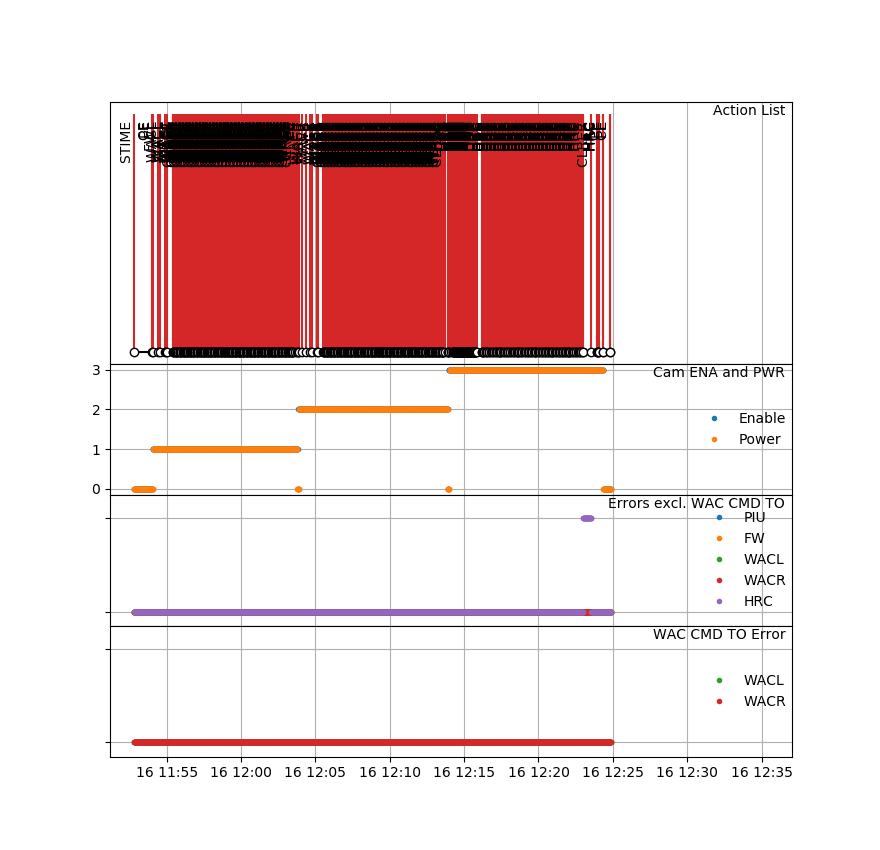

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.close("all") #Just to clear memory
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates

gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.5, 0.5, 0.5])
gs.update(hspace=0.0)
fig = plt.figure(figsize=(8.8, 8.5), constrained_layout=True)
a0 = fig.add_subplot(gs[0])
a1 = fig.add_subplot(gs[1], sharex=a0)
a2 = fig.add_subplot(gs[2], sharex=a0)
a3 = fig.add_subplot(gs[3], sharex=a0)

# Action List
size = TC.shape[0]
TC['LEVEL'] = 1

markerline, stemline, baseline = a0.stem(TC['DT'], TC['LEVEL'], linefmt='C3-', basefmt="k-", use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)
markerline.set_ydata(np.zeros(size))
a0.text(.99,.95,'Action List', horizontalalignment='right', transform=a0.transAxes)
a0.grid(True)
for i in range(0, size):
    a0.annotate(TC.ACTION.iloc[i], xy=(TC.DT.iloc[i], TC.LEVEL.iloc[i]), xytext=(0,-2),
            textcoords="offset points", va="top", ha="right", rotation=90)


## Cam Power and Enable Second dataset
a1.plot(df['DT'], df[42], '.', label='Enable')
a1.plot(df['DT'], df[43], '.', label='Power')
a1.text(.99,.9,'Cam ENA and PWR', horizontalalignment='right', transform=a1.transAxes)
a1.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)
a1.grid(True)


## Errors
a2.plot(df['DT'], df[32] != 0, '.', label='PIU')
a2.plot(df['DT'], df[33] != 0, '.', label='FW')
a2.plot(df['DT'], (df[34] != 0) & (df[34] != 0x4), '.', label='WACL')
a2.plot(df['DT'], (df[35] != 0) & (df[35] != 0x4), '.', label='WACR')
a2.plot(df['DT'], df[36] != 0, '.', label='HRC')                   

a2.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)
a2.text(.99,.9,'Errors excl. WAC CMD TO', horizontalalignment='right', transform=a2.transAxes)
a2.set_ylim([-0.15,1.25])
a2.set_yticks([0, 1], minor=False)
plt.setp(a2.get_yticklabels(), visible=False)
a2.grid(True)


## WAC CMD Timeout
a3.plot(df['DT'], df[34] == 0x4, '.', label='WACL', color = 'C2')
a3.plot(df['DT'], df[35] == 0x4, '.', label='WACR', color = 'C3')
a3.text(.99,.9,'WAC CMD TO Error', horizontalalignment='right', transform=a3.transAxes)
a3.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)
a3.set_ylim([-0.15,1.25])
a3.set_yticks([0, 1], minor=False)
plt.setp(a3.get_yticklabels(), visible=False)
a3.grid(True)


#remove y axis and spines
a0.get_yaxis().set_visible(False)

plt.setp(a0.get_xticklabels(), visible=False)
plt.setp(a1.get_xticklabels(), visible=False)
plt.setp(a2.get_xticklabels(), visible=False)
      

#Re-adjust x-axis so that 
xlimits = a0.get_xlim()
new_xlimits = (xlimits[0],(xlimits[1] - xlimits[0])*1.3+xlimits[0]);
a0.set_xlim(new_xlimits)

plt.show()

# Voltages

<IPython.core.display.Javascript object>


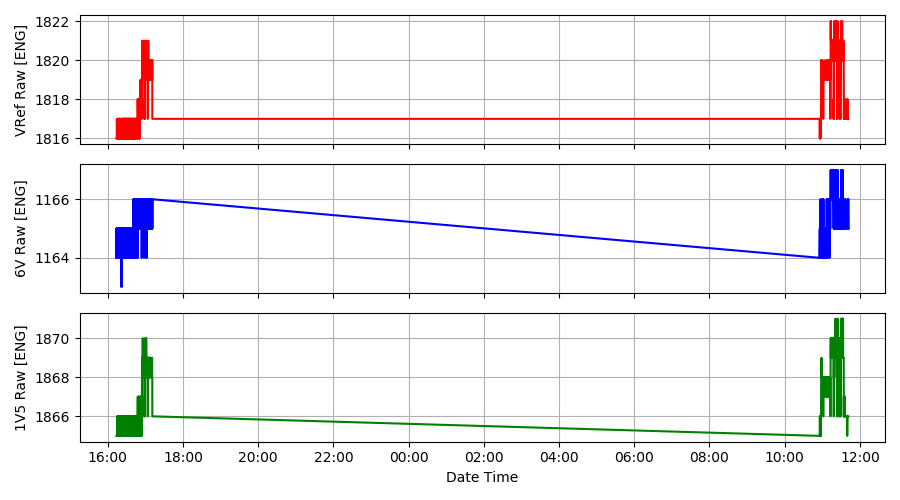

<IPython.core.display.Javascript object>


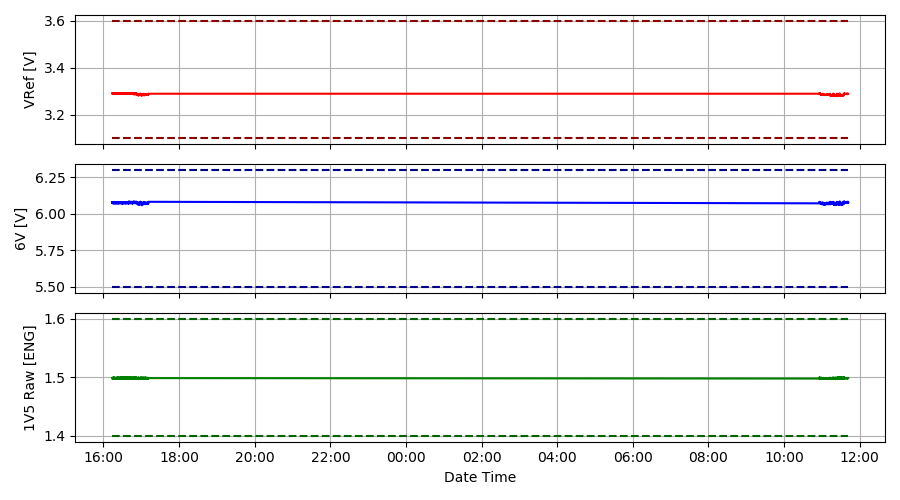

In [3]:
%matplotlib notebook
myFmt = mdates.DateFormatter('%H:%M')
plt.close("all") #Just to clear memory

#Start plot
p1 = df['DT']

fig = plt.figure(figsize=(15.0, 10.0))

ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.plot(p1, df[12]*256+df[13], 'r-', label='VRef Raw')
ax1.set_ylabel('VRef Raw [ENG]')
ax1.grid(True)

ax2.plot(p1, df[14]*256+df[15], 'b-', label='6V RAW')
ax2.set_ylabel('6V Raw [ENG]')
ax2.grid(True)
ax3.plot(p1, df[16]*256+df[17], 'g-', label='1V5 RAW')
ax3.set_ylabel('1V5 Raw [ENG]')
ax3.set_xlabel('Date Time')
ax3.grid(True)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3.xaxis.set_major_formatter(myFmt)

fig.savefig(top_dir+"\VOLT_RAW.png")

fig.set_figheight(5)
fig.set_figwidth(9)
fig.tight_layout()
fig.show()


##Plot of calibrated values
ratio = 4096*1.45914
p2 = ratio /(df[12]*256+df[13])
p3 = p2 / 4096 * 6.4945 * (df[14]*256+df[15])
p4 = p2 * (df[16]*256+df[17])/4096

fig = plt.figure()

ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax3 = fig.add_subplot(3,1,3, sharex=ax1)

ax1.plot(p1, p2, 'r-', label='VRef')
ax1.plot([df['DT'].iloc[0], df['DT'].iloc[-1]], [3.1, 3.1], 'darkred', linestyle='dashed')
ax1.plot([df['DT'].iloc[0], df['DT'].iloc[-1]], [3.6, 3.6], 'darkred', linestyle='dashed')
ax1.set_ylabel('VRef [V]')
ax1.grid(True)

ax2.plot(p1, p3, 'b-', label='6V')
ax2.set_ylabel('6V [V]')
ax2.plot([df['DT'].iloc[0], df['DT'].iloc[-1]], [5.5, 5.5], 'darkblue', linestyle='dashed')
ax2.plot([df['DT'].iloc[0], df['DT'].iloc[-1]], [6.3, 6.3], 'darkblue', linestyle='dashed')
ax2.grid(True)

ax3.plot(p1, p4, 'g-', label='1V5 RAW')
ax3.set_ylabel('1V5 Raw [ENG]')as
ax3.plot([df['DT'].iloc[0], df['DT'].iloc[-1]], [1.4, 1.4], 'darkgreen', linestyle='dashed')
ax3.plot([df['DT'].iloc[0], df['DT'].iloc[-1]], [1.6, 1.6], 'darkgreen', linestyle='dashed')
ax3.set_xlabel('Date Time')
ax3.grid(True)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3.xaxis.set_major_formatter(myFmt)


#Display Plot
fig.set_figheight(8)
fig.set_figwidth(15)
fig.tight_layout()
fig.savefig(top_dir+"\VOLT_CAL.png")

fig.set_figheight(5)
fig.set_figwidth(9)
fig.tight_layout()
fig.show()

# Temperatures

<IPython.core.display.Javascript object>


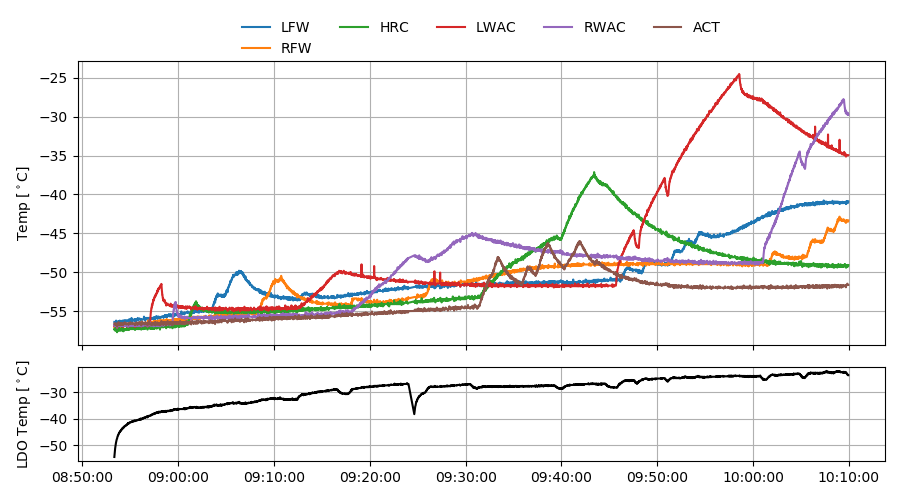

In [15]:
%matplotlib notebook

Cal_A = [306.90, 308.57, 313.57, 307.91, 307.17, 310.42, 304.15]
Cal_B = [-268.21, -268.14, -274.94, -267.41, -266.71, -270.04, -264.52]

rREF = df[12]*256+df[13]

#Start plot
p1 = df['DT']

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
f = plt.figure()
    
a0 = f.add_subplot(gs[0])
a1 = f.add_subplot(gs[1], sharex=a0)

LFW_T  =  (df[18]*256+df[19])*Cal_A[0]/rREF + Cal_B[0]
RFW_T  =  (df[20]*256+df[21])*Cal_A[1]/rREF + Cal_B[1]
HRC_T  =  (df[22]*256+df[23])*Cal_A[2]/rREF + Cal_B[2]
LWAC_T = (df[24]*256+df[25])*Cal_A[3]/rREF + Cal_B[3]
RWAC_T = (df[26]*256+df[27])*Cal_A[4]/rREF + Cal_B[4]
LDO_T  =  (df[28]*256+df[29])*Cal_A[5]/rREF + Cal_B[5]
ACT_T  =  (df[30]*256+df[31])*Cal_A[6]/rREF + Cal_B[6]

a0.plot(p1, LFW_T, label='LFW')
a0.plot(p1, RFW_T, label='RFW')
a0.plot(p1, HRC_T, label='HRC')
a0.plot(p1, LWAC_T,label='LWAC')
a0.plot(p1, RWAC_T,label='RWAC')
a0.plot(p1, ACT_T, label='ACT')
a1.plot(p1, LDO_T, '-k',label='LDO')
a0.grid(True)
a1.grid(True)
a0.set_ylabel('Temp [$^\circ$C]')
a0.legend(loc='lower center', bbox_to_anchor= (0.5, 1.0), ncol=5, borderaxespad=0, frameon=False)
a1.set_ylabel('LDO Temp [$^\circ$C]')

myFmt = mdates.DateFormatter('%H:%M:%S')
a1.xaxis.set_major_formatter(myFmt)
plt.setp(a0.get_xticklabels(), visible=False)

#Display Plot
f.set_figheight(8)
f.set_figwidth(15)
f.tight_layout()
f.savefig(top_dir+"\Temp_Cal.png")

f.set_figheight(5)
f.set_figwidth(9)
f.tight_layout()
f.show()

## Database calibration

<IPython.core.display.Javascript object>


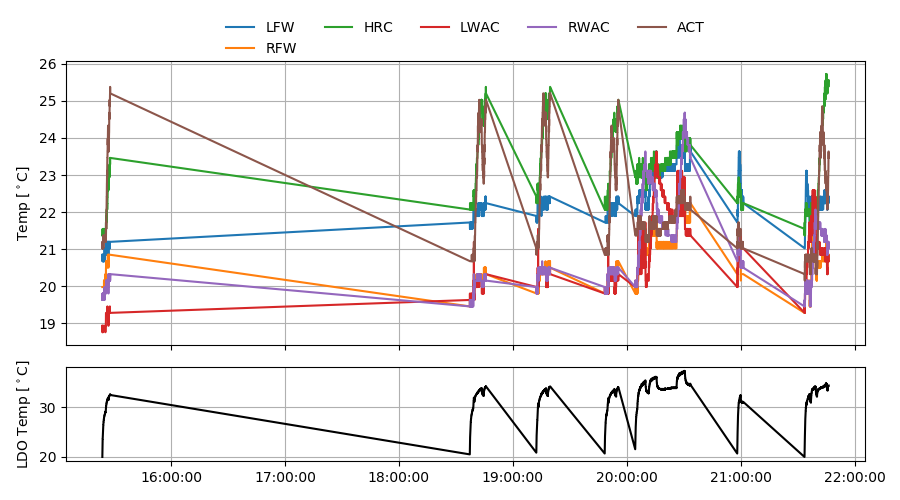

In [19]:
%matplotlib notebook

Cal_A = 0.174221209411
Cal_B = -277.94

#Start plot
p1 = df['DT']

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
f = plt.figure()
    
a0 = f.add_subplot(gs[0])
a1 = f.add_subplot(gs[1], sharex=a0)

LFW  =  (df[18]*256+df[19])*Cal_A + Cal_B
RFW  =  (df[20]*256+df[21])*Cal_A + Cal_B
HRC  =  (df[22]*256+df[23])*Cal_A + Cal_B
LWAC =  (df[24]*256+df[25])*Cal_A + Cal_B
RWAC =  (df[26]*256+df[27])*Cal_A + Cal_B
LDO  =  (df[28]*256+df[29])*Cal_A + Cal_B
ACT  =  (df[30]*256+df[31])*Cal_A + Cal_B

a0.plot(p1, LFW, label='LFW')
a0.plot(p1, RFW, label='RFW')
a0.plot(p1, HRC, label='HRC')
a0.plot(p1, LWAC,label='LWAC')
a0.plot(p1, RWAC,label='RWAC')
a0.plot(p1, ACT, label='ACT')
a1.plot(p1, LDO, '-k',label='LDO')
a0.grid(True)
a1.grid(True)
a0.set_ylabel('Temp [$^\circ$C]')
a0.legend(loc='lower center', bbox_to_anchor= (0.5, 1.0), ncol=5, borderaxespad=0, frameon=False)
a1.set_ylabel('LDO Temp [$^\circ$C]')

myFmt = mdates.DateFormatter('%H:%M:%S')
a1.xaxis.set_major_formatter(myFmt)
plt.setp(a0.get_xticklabels(), visible=False)

#Display Plot
f.set_figheight(8)
f.set_figwidth(15)
f.tight_layout()

f.set_figheight(5)
f.set_figwidth(9)
f.tight_layout()
f.show()

# Raw Temperatures and Heaters

<IPython.core.display.Javascript object>


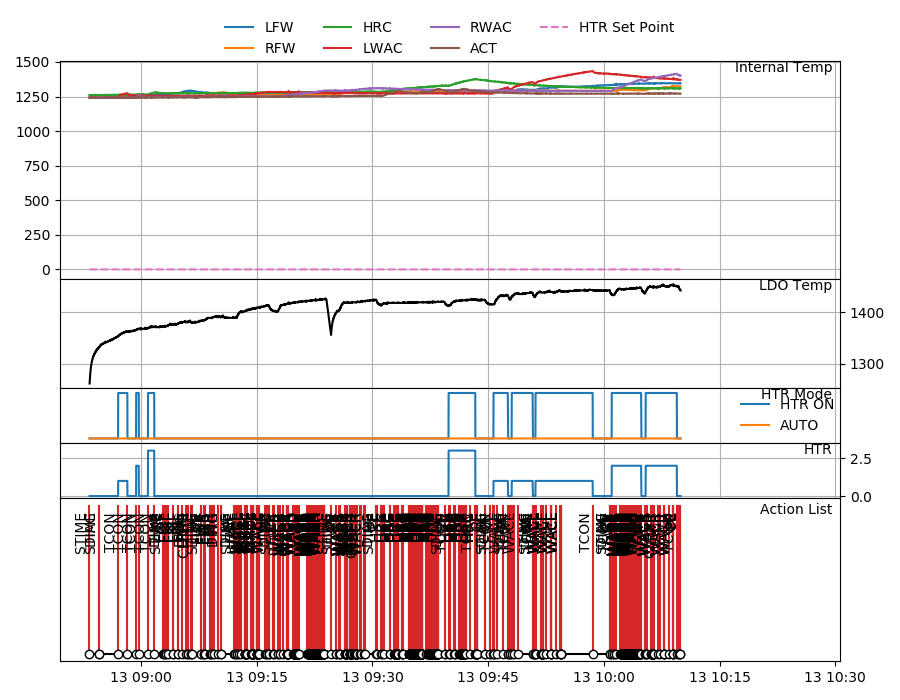

In [11]:
%matplotlib notebook

#Start plot
p1 = df['DT']

gs = gridspec.GridSpec(5, 1, height_ratios=[2, 1, 0.5, 0.5, 1.5])
gs.update(hspace=0.0)
f = plt.figure()
    
a0 = f.add_subplot(gs[0])
a1 = f.add_subplot(gs[1], sharex=a0)
a2 = f.add_subplot(gs[2], sharex=a0)
a3 = f.add_subplot(gs[3], sharex=a0)
a4 = f.add_subplot(gs[4], sharex=a0)

LFW  =  df[18]*256+df[19]
RFW  =  df[20]*256+df[21]
HRC  =  df[22]*256+df[23]
LWAC =  df[24]*256+df[25]
RWAC =  df[26]*256+df[27]
LDO  =  df[28]*256+df[29]
ACT  =  df[30]*256+df[31]

def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

a0.plot(p1, LFW, label='LFW')
a0.plot(p1, RFW, label='RFW')
a0.plot(p1, HRC, label='HRC')
a0.plot(p1, LWAC,label='LWAC')
a0.plot(p1, RWAC,label='RWAC')
a0.plot(p1, ACT, label='ACT')
a0.plot(p1, ((df[38]&0x0F).values << 8) + df[39], '--', label='HTR Set Point')
a0.grid(True)
a0.legend(loc='lower center', bbox_to_anchor= (0.5, 1.0), ncol=4, borderaxespad=0, frameon=False)
a0.text(.99,.95,'Internal Temp', horizontalalignment='right', transform=a0.transAxes)


a1.plot(p1, LDO, '-k',label='LDO')
a1.grid(True)
a1.text(.99,.9,'LDO Temp', horizontalalignment='right', transform=a1.transAxes)
a1.yaxis.tick_right()
a1.yaxis.set_label_position('right')

a2.plot(p1, (df[38]&0x80).values >> 7, label = 'HTR ON')
a2.plot(p1, (df[38]&0x40).values >> 6, label = 'AUTO')
a2.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)
a2.set_ylim([-0.1,1.1])
a2.get_yaxis().set_visible(False)
a2.grid(True)
a2.text(.99,.8,'HTR Mode', horizontalalignment='right', transform=a2.transAxes)

a3.plot(p1, (df[38]&0x30).values >> 4, label = 'HTR')
a3.set_ylim([-0.1,3.5])
a3.grid(True)
a3.text(.99,.8,'HTR', horizontalalignment='right', transform=a3.transAxes)
a3.yaxis.tick_right()
a3.yaxis.set_label_position('right')

myFmt = mdates.DateFormatter('%H:%M:%S')
a3.xaxis.set_major_formatter(myFmt)
plt.setp(a0.get_xticklabels(), visible=False)
plt.setp(a1.get_xticklabels(), visible=False)
plt.setp(a2.get_xticklabels(), visible=False)

markerline, stemline, baseline = a4.stem(TC['DT'], TC['LEVEL'], linefmt='C3-', basefmt="k-", use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)
markerline.set_ydata(np.zeros(size))
a4.text(.99,.9,'Action List', horizontalalignment='right', transform=a4.transAxes)
a4.get_yaxis().set_visible(False)
for i in range(0, size):
    a4.annotate(TC.ACTION.iloc[i], xy=(TC.DT.iloc[i], TC.LEVEL.iloc[i]), xytext=(0,-2),
            textcoords="offset points", va="top", ha="right", rotation=90)

#Rescale x-axis to avoid clash with labels
xlimits = a0.get_xlim()
new_xlimits = (xlimits[0],(xlimits[1] - xlimits[0])*1.2+xlimits[0]);
a0.set_xlim(new_xlimits)

plt.setp(a0.get_xticklabels(), visible=False)
plt.setp(a1.get_xticklabels(), visible=False)
plt.setp(a2.get_xticklabels(), visible=False)
plt.setp(a3.get_xticklabels(), visible=False)

#Display Plot
f.set_figheight(13)
f.set_figwidth(15)
f.tight_layout()
f.savefig(top_dir+"\Temp.png")

f.set_figheight(7)
f.set_figwidth(9)
f.tight_layout()
f.show()

# Filter Wheel 

<IPython.core.display.Javascript object>


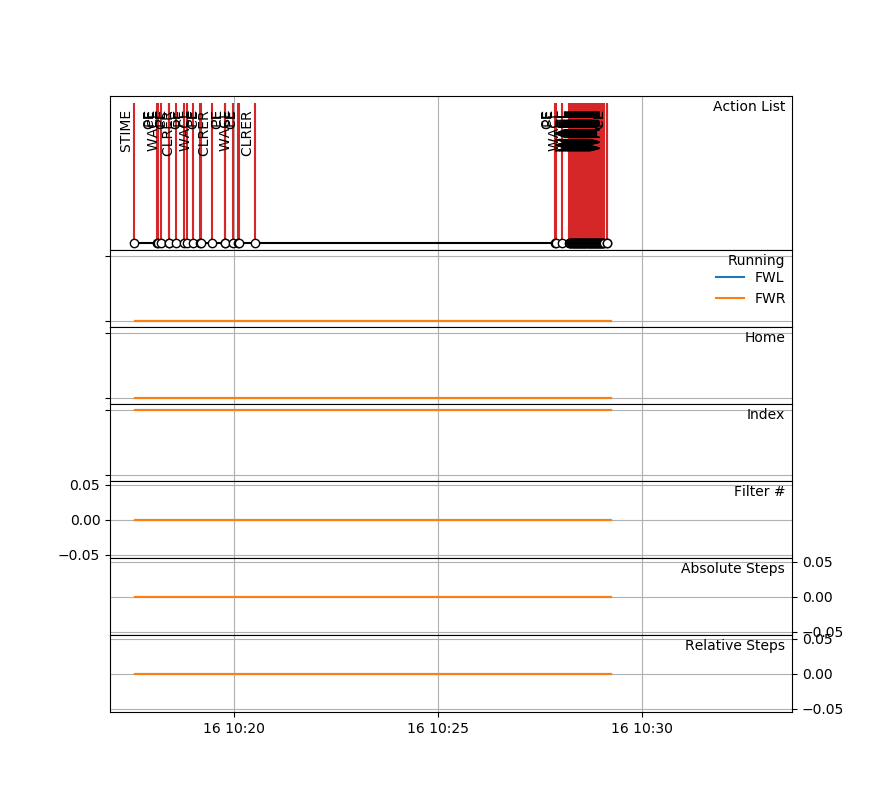

In [6]:
%matplotlib notebook

gs = gridspec.GridSpec(7, 1, height_ratios=[1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
gs.update(hspace=0.0)
fig = plt.figure(figsize=(8.8, 8), constrained_layout=True)
a0 = fig.add_subplot(gs[0])
a1 = fig.add_subplot(gs[1], sharex=a0)
a2 = fig.add_subplot(gs[2], sharex=a0)
a3 = fig.add_subplot(gs[3], sharex=a0)
a4 = fig.add_subplot(gs[4], sharex=a0)
a5 = fig.add_subplot(gs[5], sharex=a0)
a6 = fig.add_subplot(gs[6], sharex=a0)

# Action List
size = TC.shape[0]
TC['LEVEL'] = 1

markerline, stemline, baseline = a0.stem(TC['DT'], TC['LEVEL'], linefmt='C3-', basefmt="k-", use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)
markerline.set_ydata(np.zeros(size))
a0.text(.99,.9,'Action List', horizontalalignment='right', transform=a0.transAxes)
a0.grid(True)
for i in range(0, size):
    a0.annotate(TC.ACTION.iloc[i], xy=(TC.DT.iloc[i], TC.LEVEL.iloc[i]), xytext=(0,-2),
            textcoords="offset points", va="top", ha="right", rotation=90)


## Cam Power and Enable Second dataset
a1.plot(df['DT'], (df[40]&0x40).values>6, label='FWL')
a1.plot(df['DT'], (df[41]&0x40).values>6, label='FWR')
a1.text(.99,.8,'Running', horizontalalignment='right', transform=a1.transAxes)
a1.grid(True)
a1.set_ylim([-0.1,1.1])
plt.setp(a1.get_yticklabels(), visible=False)
a1.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)

## Home Effect
a2.plot(df['DT'], (df[40]&0x20).values>5)
a2.plot(df['DT'], (df[41]&0x20).values>5)
a2.text(.99,.8,'Home', horizontalalignment='right', transform=a2.transAxes)
a2.grid(True)
a2.set_ylim([-0.1,1.1])
plt.setp(a2.get_yticklabels(), visible=False)

## Index Number
a3.plot(df['DT'], (df[40]&0x10).values>4)
a3.plot(df['DT'], (df[41]&0x10).values>4)
a3.text(.99,.8,'Index', horizontalalignment='right', transform=a3.transAxes)
a3.grid(True)
a3.set_ylim([-0.1,1.1])
plt.setp(a3.get_yticklabels(), visible=False)

## WAC CMD Timeout
a4.plot(df['DT'], (df[40]&0xF))
a4.plot(df['DT'], (df[41]&0xF))
a4.text(.99,.8,'Filter #', horizontalalignment='right', transform=a4.transAxes)
a4.grid(True)

## Absolute Steps
a5.plot(df['DT'], (df[64]*256+df[65]))
a5.plot(df['DT'], (df[66]*256+df[67]))
a5.text(.99,.8,'Absolute Steps', horizontalalignment='right', transform=a5.transAxes)
a5.grid(True)
a5.yaxis.tick_right()
a5.yaxis.set_label_position('right')

# Relative Steps
a6.plot(df['DT'], (df[68]*256+df[69]))
a6.plot(df['DT'], (df[70]*256+df[71]))
a6.text(.99,.8,'Relative Steps', horizontalalignment='right', transform=a6.transAxes)
a6.grid(True)
a6.yaxis.tick_right()
a6.yaxis.set_label_position('right')

#remove y axis and spines
a0.get_yaxis().set_visible(False)
        
#Re-adjust x-axis so that 
xlimits = a0.get_xlim()
new_xlimits = (xlimits[0],(xlimits[1] - xlimits[0])*1.3+xlimits[0]);
a0.set_xlim(new_xlimits)

plt.show()

# Other HK Settings

In [7]:
# Check if some values are consistent
# PIU Version
ver = (df.iloc[0,78]*256 + df.iloc[0,79])
ver_chn = ((df[78].nunique() == 1 & df[79].nunique() == 1))
print("PIU Version: ", ver, "\t\t Unchanged: ", ver_chn)

# Filter Wheel Speed
spd = (df.iloc[0,80:82])
spd_chn = (df[80].nunique() == 1) & (df[81].nunique() == 1)
print("Fwl Speed  :", spd.values, "\t Unchanged: ", spd_chn)

# Filter Wheel Current
lfw = (df.iloc[0,82:84])
lfw_chn = (df[82].nunique() == 1) & (df[83].nunique() == 1)
print("LFW Current:", lfw.values, "\t Unchanged: ", lfw_chn)

rfw = (df.iloc[0,84:86])
rfw_chn = (df[84].nunique() == 1) & (df[85].nunique() == 1)
print("RFW Current:", rfw.values, "\t Unchanged: ", rfw_chn)

# Step Level Factor
stp = (df.iloc[0,86:88])
stp_chn = (df[86].nunique() == 1) & (df[87].nunique() == 1)
print("Step Lvl   :", stp.values, "\t Unchanged: ", stp_chn)

PIU Version:  0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000 		 Unchanged:  True
Fwl Speed  : ['01' '20'] 	 Unchanged:  True
LFW Current: ['3E' '44'] 	 Unchanged:  True
RFW Current: ['61' 'A8'] 	 Unchanged:  True
Step Lvl   : ['61' 'A8'] 	 Unchanged:  True


# WAC Decoding
## Housekeeping

In [12]:
WHK = df[(df[44]&0xC0==0x40) & ((df[43]==0x1) | (df[43]==0x2))] # Filter HK by 01 in 1st Cam byte and PWR Mode = 1 or 2

# Start Marker
sm_chn = (WHK[44]&0x20==0x20).nunique() == 1
print("Start MRK always 0x1:", sm_chn)

# Memory Checks
mc = (WHK[44]&0x18).unique()
mc_chn = (1 in mc) or (2 in mc)
print("Memory Check Performed: ", mc_chn)

if 1 in mc:
    print("    Memory Check Successful Reported")
if 2 in mc:
    print("    Memory Check Failure Reported")

Start MRK always 0x1: True
Memory Check Performed:  False


In [9]:
(WHK[58]&0x03).unique()

array([2, 3], dtype=int64)

<IPython.core.display.Javascript object>


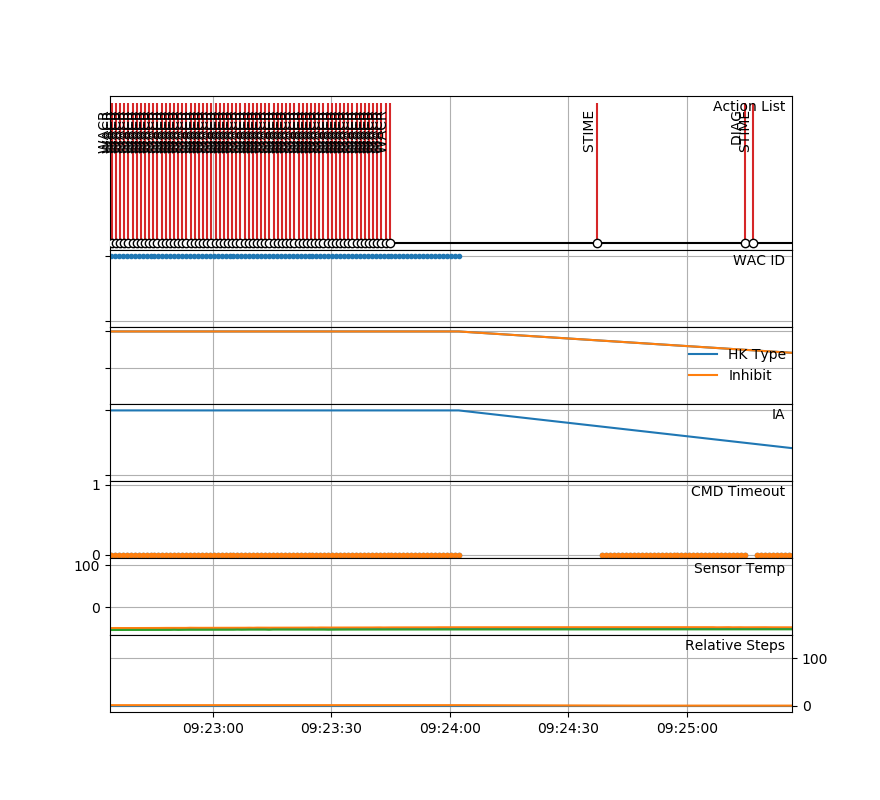

In [17]:
%matplotlib notebook

gs = gridspec.GridSpec(7, 1, height_ratios=[1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
gs.update(hspace=0.0)
fig = plt.figure(figsize=(8.8, 8), constrained_layout=True)
a0 = fig.add_subplot(gs[0])
a1 = fig.add_subplot(gs[1], sharex=a0)
a2 = fig.add_subplot(gs[2], sharex=a0)
a3 = fig.add_subplot(gs[3], sharex=a0)
a4 = fig.add_subplot(gs[4], sharex=a0)
a5 = fig.add_subplot(gs[5], sharex=a0)
a6 = fig.add_subplot(gs[6], sharex=a0)

# Action List
size = TC.shape[0]
TC['LEVEL'] = 1

markerline, stemline, baseline = a0.stem(TC['DT'], TC['LEVEL'], linefmt='C3-', basefmt="k-", use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)
markerline.set_ydata(np.zeros(size))
a0.text(.99,.9,'Action List', horizontalalignment='right', transform=a0.transAxes)
a0.grid(True)
for i in range(0, size):
    a0.annotate(TC.ACTION.iloc[i], xy=(TC.DT.iloc[i], TC.LEVEL.iloc[i]), xytext=(0,-2),
            textcoords="offset points", va="top", ha="right", rotation=90)

## WAC ID
a1.plot(WHK['DT'], (WHK[44]&0x07), '.')
a1.text(.99,.8,'WAC ID', horizontalalignment='right', transform=a1.transAxes)
a1.grid(True)
a1.set_ylim([-0.1,1.1])
plt.setp(a1.get_yticklabels(), visible=False)

## Normal HK or EXT
a2.plot(WHK['DT'], (WHK[44]&0x0C).values>2, label='HK Type')
a2.plot(WHK['DT'], (WHK[58]&0x08).values>3, label='Inhibit')
a2.grid(True)
a2.set_ylim([-0.1,1.1])
plt.setp(a2.get_yticklabels(), visible=False)
a2.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)

## Image Acquisition
a3.plot(WHK['DT'], (WHK[58]&0x04).values>3)
a3.text(.99,.8,'IA', horizontalalignment='right', transform=a3.transAxes)
a3.grid(True)
a3.set_ylim([-0.1,1.1])
plt.setp(a3.get_yticklabels(), visible=False)

## WAC CMD Timeout
a4.plot(df['DT'], df[34] == 0x4, '.', label='WACL')
a4.plot(df['DT'], df[35] == 0x4, '.', label='WACR')
a4.text(.99,.8,'CMD Timeout', horizontalalignment='right', transform=a4.transAxes)
a4.grid(True)

## Temperature
RT = ((((WHK[57]&0x7F)*256 + (WHK[58]&0xF0)).values>>4))/8 + (WHK[57]&0x80==0x80)*(-2047/8)
a5.plot(df['DT'], LWAC_T)
a5.plot(df['DT'], RWAC_T)
a5.plot(WHK['DT'], RT)
a5.text(.99,.8,'Sensor Temp', horizontalalignment='right', transform=a5.transAxes)
a5.grid(True)

# Relative Steps
a6.plot(df['DT'], (df[68]*256+df[69]))
a6.plot(df['DT'], (df[70]*256+df[71]))
a6.text(.99,.8,'Relative Steps', horizontalalignment='right', transform=a6.transAxes)
a6.grid(True)
a6.yaxis.tick_right()
a6.yaxis.set_label_position('right')

#remove y axis and spines
a0.get_yaxis().set_visible(False)

#remove x-xis for all but last
plt.setp(a0.get_xticklabels(), visible=False)
plt.setp(a1.get_xticklabels(), visible=False)
plt.setp(a2.get_xticklabels(), visible=False)
plt.setp(a3.get_xticklabels(), visible=False)
plt.setp(a4.get_xticklabels(), visible=False)
plt.setp(a5.get_xticklabels(), visible=False)
        
#Re-adjust x-axis so that 
xlimits = a0.get_xlim()
new_xlimits = (xlimits[0],(xlimits[1] - xlimits[0])*1.3+xlimits[0]);
a0.set_xlim(new_xlimits)

plt.show()

## HRC Decoding

## Camera Status

In [27]:
HRC = df[(df[51]==0x02) & (df[43]==0x3) ] # Filter HK by 0x02 in 7th Cam byte and PWR Mode = 3


# Check that the last HRC HK received has the encoder value at 188
Parked = ((((HRC[47].iloc[-1]*256)+HRC[48].iloc[-1])&0x3FF0)>>4 ) == 188
print("HRC Last Position Parked: ", Parked)

HRC Last Position Parked:  True


<IPython.core.display.Javascript object>


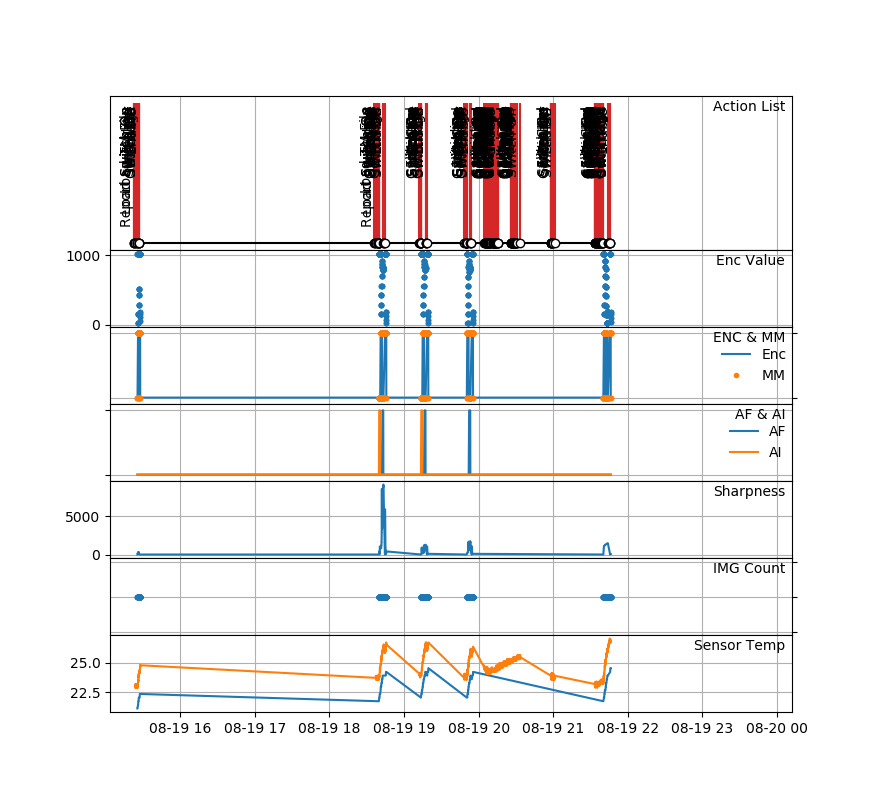

In [30]:
%matplotlib notebook

gs = gridspec.GridSpec(7, 1, height_ratios=[1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
gs.update(hspace=0.0)
fig = plt.figure(figsize=(8.8, 8), constrained_layout=True)
a0 = fig.add_subplot(gs[0])
a1 = fig.add_subplot(gs[1], sharex=a0)
a2 = fig.add_subplot(gs[2], sharex=a0)
a3 = fig.add_subplot(gs[3], sharex=a0)
a4 = fig.add_subplot(gs[4], sharex=a0)
a5 = fig.add_subplot(gs[5], sharex=a0)
a6 = fig.add_subplot(gs[6], sharex=a0)

# Action List
size = TC.shape[0]
TC['LEVEL'] = 1

markerline, stemline, baseline = a0.stem(TC['DT'], TC['LEVEL'], linefmt='C3-', basefmt="k-", use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)
markerline.set_ydata(np.zeros(size))
a0.text(.99,.9,'Action List', horizontalalignment='right', transform=a0.transAxes)
a0.grid(True)
for i in range(0, size):
    a0.annotate(TC.ACTION.iloc[i], xy=(TC.DT.iloc[i], TC.LEVEL.iloc[i]), xytext=(0,-2),
            textcoords="offset points", va="top", ha="right", rotation=90)

## Encoder Value
a1.plot(HRC['DT'], (((HRC[47]*256)+HRC[48])&0x3FF0).values>>4, '.')
a1.text(.99,.8,'Enc Value', horizontalalignment='right', transform=a1.transAxes)
a1.grid(True)

## Enc and MM Flag
a2.plot(HRC['DT'], (HRC[48]&0x08).values>3, label='Enc')
a2.plot(HRC['DT'], (HRC[48]&0x01),'.'     , label='MM')
a2.text(.99,.8,'ENC & MM', horizontalalignment='right', transform=a2.transAxes)
a2.grid(True)
a2.set_ylim([-0.1,1.1])
a2.yaxis.tick_right()
a2.yaxis.set_label_position('right')
plt.setp(a2.get_yticklabels(), visible=False)
a2.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)


## AF and AI Flag
a3.plot(HRC['DT'], (HRC[48]&0x02).values>1, label='AF')
a3.plot(HRC['DT'], (HRC[48]&0x04).values>2, label='AI')
a3.text(.99,.8,'AF & AI', horizontalalignment='right', transform=a3.transAxes)
a3.grid(True)
a3.set_ylim([-0.1,1.1])
plt.setp(a3.get_yticklabels(), visible=False)
a3.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)

## Current Sharpness
a4.plot(HRC['DT'], (HRC[44]*256)+HRC[45])
a4.text(.99,.8,'Sharpness', horizontalalignment='right', transform=a4.transAxes)
a4.grid(True)

## Image Counter
a5.plot(HRC['DT'], HRC[49], '.')
a5.text(.99,.8,'IMG Count', horizontalalignment='right', transform=a5.transAxes)
a5.grid(True)
a5.yaxis.tick_right()
plt.setp(a5.get_yticklabels(), visible=False)
a5.yaxis.set_label_position('right')

# Sensor Temp
RT = (((HRC[46]*256+HRC[47])&0xFFC0).values>>6).astype(float)
a6.plot(HRC['DT'], (1.235e-9*RT**4 -2.029e-6*RT**3 +1.415e-3*RT**2 -2.612e-1*RT -49.631))
a6.plot(df['DT'], HRC_T)
a6.text(.99,.8,'Sensor Temp', horizontalalignment='right', transform=a6.transAxes)
a6.grid(# Action List
size = TC.shape[0]
TC['LEVEL'] = 1

markerline, stemline, baseline = a0.stem(TC['DT'], TC['LEVEL'], linefmt='C3-', basefmt="k-", use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)
markerline.set_ydata(np.zeros(size))
a0.text(.99,.9,'Action List', horizontalalignment='right', transform=a0.transAxes)
a0.grid(True)
for i in range(0, size):
    a0.annotate(TC.ACTION.iloc[i], xy=(TC.DT.iloc[i], TC.LEVEL.iloc[i]), xytext=(0,-2),
            textcoords="offset points", va="top", ha="right", rotation=90)
